In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, precision_score, confusion_matrix
from sklearn.model_selection import cross_validate, RandomizedSearchCV
from tabulate import tabulate
from xgboost import XGBClassifier


In [123]:
# Load the dataset
file_path = 'credit_risk_dataset.csv'
data = pd.read_csv(file_path)

data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [124]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [126]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [127]:
# Handling outliers
# For 'person_age' remove all the records of age above 79
data = data.drop(data[data['person_age']>79].index)

# For 'person_age' remove all the records of length above 50
data = data.drop(data[data['person_emp_length']>50].index)

# Reference: https://www.analyticsvidhya.com/blog/2022/10/handling-missing-data-with-simpleimputer/
# Impute missing values by using median
imputer = SimpleImputer(strategy='median')
data[['person_emp_length', 'loan_int_rate']] = imputer.fit_transform(data[['person_emp_length', 'loan_int_rate']])

# Check the dataset after handling missing values and outliers
data.describe()


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32571.000000,3.257100e+04,32571.000000,32571.000000,32571.000000,32571.00000,32571.000000,32571.000000
mean,27.713058,6.587894e+04,4.760707,9588.185809,11.009556,0.21820,0.170202,5.802309
std,6.179751,5.253360e+04,3.981262,6320.498213,3.081742,0.41303,0.106757,4.049707
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.00000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.00000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.00000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.00000,0.230000,8.000000
max,78.000000,2.039784e+06,41.000000,35000.000000,23.220000,1.00000,0.830000,30.000000


In [128]:
# Feature Engineering

data['age_group'] = pd.cut(data['person_age'], 
                           bins=[19,30,40,50,60,70,80], 
                           labels=['20-29','30-39','40-49','50-59','60-69','70-79'])

data['income_group'] = pd.cut(data['person_income'],
                              bins=[0, 25000, 50000, 75000, 100000, float('inf')],
                              labels=['low', 'low-middle', 'middle', 'high-middle', 'high'])

data['loan_to_income_ratio'] = data['loan_amnt'] / data['person_income']

data = data.drop(columns=['loan_grade', 'loan_percent_income'])

# Check the dataset after feature engineering
data.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_amnt', 'loan_int_rate',
       'loan_status', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'age_group', 'income_group',
       'loan_to_income_ratio'],
      dtype='object')

In [129]:
#Reference: https://www.geeksforgeeks.org/ml-one-hot-encoding/
# Encoding categorical variables
ohe = OneHotEncoder()
nominal_columns = ['person_home_ownership', 'loan_intent', 'age_group', 'income_group']
ohe_columns = ohe.fit_transform(data[nominal_columns])
ohe_df = pd.DataFrame(
    ohe_columns.toarray(),
    columns = ohe.get_feature_names_out(nominal_columns),
    index=data.index
)

# For the binary variable 'cb_person_default_on_file', map the values directly to 0 and 1
data['cb_person_default_on_file_encoded'] = data['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

# Drop the original nominal and ordinal columns that have been encoded
data = data.drop(columns=nominal_columns + ['cb_person_default_on_file'])

# Concatenate the one-hot encoded dataframe with the original dataframe
data_encoded = pd.concat([data, ohe_df], axis=1)

# Display the first few rows of the new dataframe to confirm the changes
data_encoded.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,cb_person_cred_hist_length,loan_to_income_ratio,cb_person_default_on_file_encoded,person_home_ownership_MORTGAGE,...,age_group_30-39,age_group_40-49,age_group_50-59,age_group_60-69,age_group_70-79,income_group_high,income_group_high-middle,income_group_low,income_group_low-middle,income_group_middle
1,21,9600,5.0,1000,11.14,0,2,0.104167,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,25,9600,1.0,5500,12.87,1,3,0.572917,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,23,65500,4.0,35000,15.23,1,2,0.534351,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,24,54400,8.0,35000,14.27,1,4,0.643382,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,21,9900,2.0,2500,7.14,1,2,0.252525,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [130]:
# Drop the target variable 'loan_status' 
X = data_encoded.drop(['loan_status'], axis=1) 
Y = data_encoded['loan_status']

# Split the dataset into training and testing set
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=20)
x_train.reset_index(drop = True,inplace = True)
x_test.reset_index(drop = True,inplace = True)
x_train.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'cb_person_cred_hist_length', 'loan_to_income_ratio',
       'cb_person_default_on_file_encoded', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'age_group_20-29', 'age_group_30-39', 'age_group_40-49',
       'age_group_50-59', 'age_group_60-69', 'age_group_70-79',
       'income_group_high', 'income_group_high-middle', 'income_group_low',
       'income_group_low-middle', 'income_group_middle'],
      dtype='object')

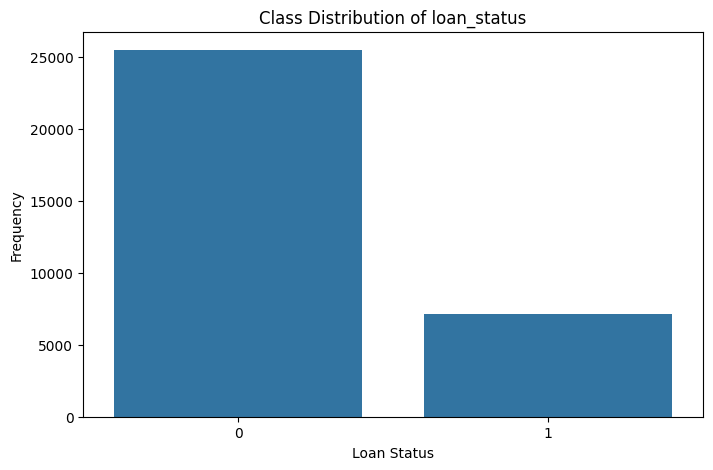

In [131]:
# Display the distribution of 'loan_status' to check if it is balanced
plt.figure(figsize=(8, 5))
sns.countplot(x=Y)
plt.title('Class Distribution of loan_status')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.show()

#References: https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html
# Implement SMOTE for oversampling to balance the dataset
smote = SMOTE(random_state=20)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

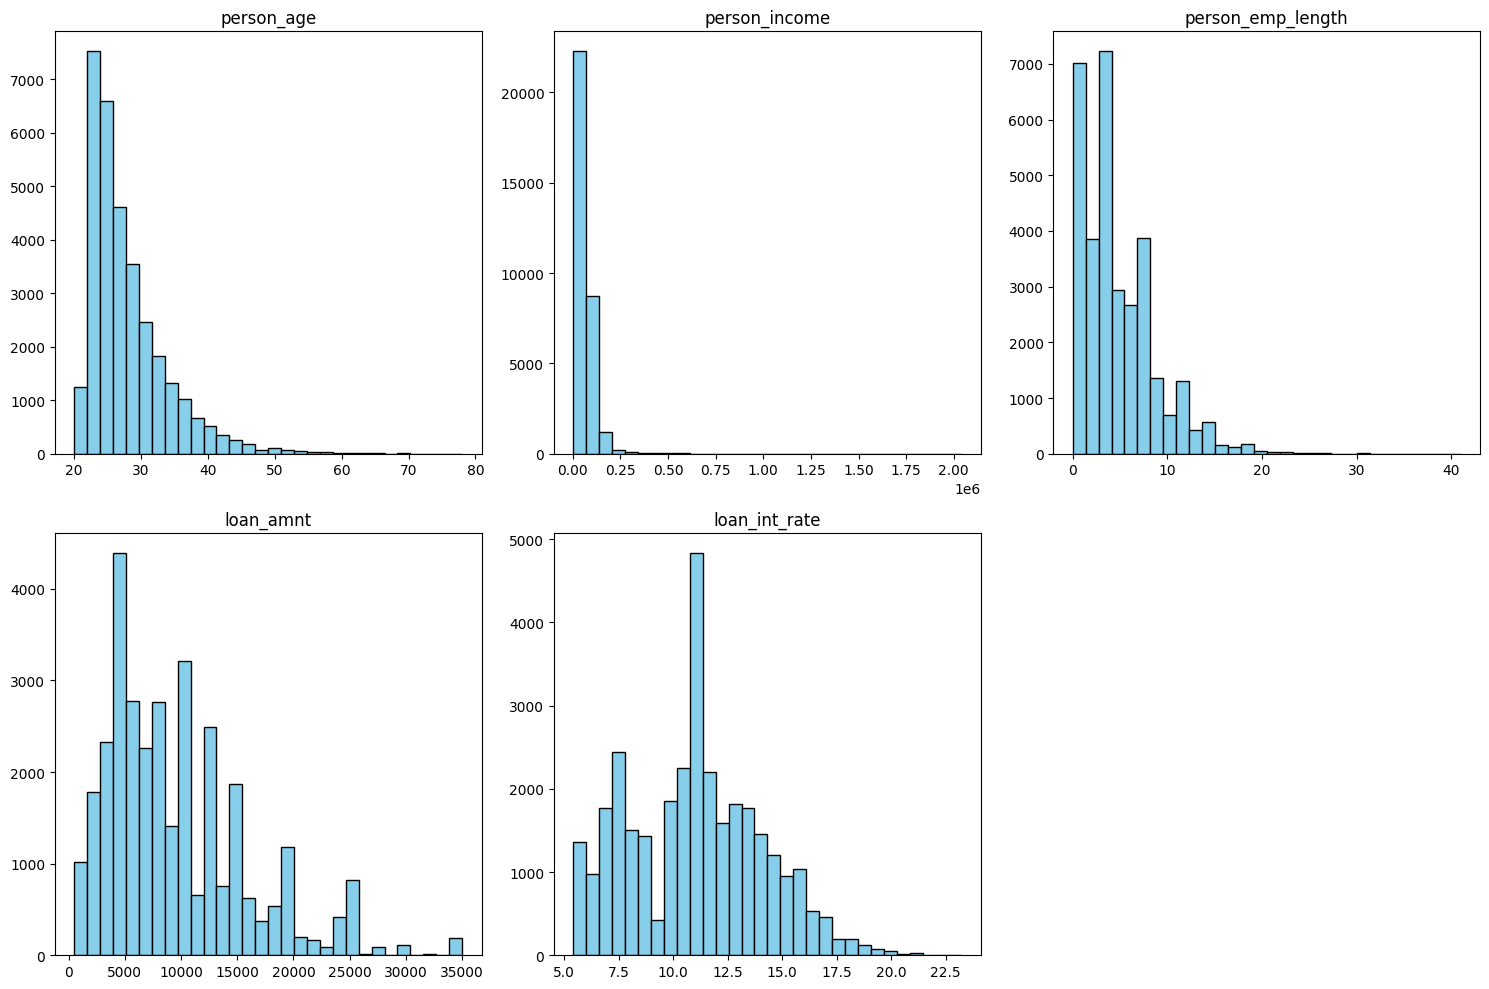

In [132]:
# Print out the distribution of the data
numerical_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate']
num_features = len(numerical_features)
fig = plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features):
    ax = fig.add_subplot((num_features + 2) // 3, 3, i+1)
    ax.hist(data[feature], bins=30, color='skyblue', edgecolor='black')
    ax.set_title(feature)

plt.tight_layout()
plt.show()

In [133]:
#References: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
# Feature Scaling

# Initialize the MinMaxScaler
mmscaler = MinMaxScaler()

# Fit the scaler to the training data and transform it
x_train_smote = mmscaler.fit_transform(x_train_smote)

# Transform the test data with the same scaler
x_test = mmscaler.transform(x_test)

In [134]:
#References: https://scikit-learn.org/stable/modules/cross_validation.html
#            https://github.com/kulkarni-vishwanath/Evaluation_Metrics/blob/main/Classification_Regression_Evaluation_Metrics.ipynb
             
# Model Training
# Dictionary to hold the models we want to train
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=20),
    "Decision Tree": DecisionTreeClassifier(random_state=20),
    "Random Forest": RandomForestClassifier(random_state=20),  
    "KNN": KNeighborsClassifier(),  
    "XGBoost": XGBClassifier(random_state=20)  
}

# Function to calculate specificity
def calc_specificity(y_test,y_pred):
    tn, fp, _, _ = confusion_matrix(y_test, y_pred).ravel()
    return tn / (tn + fp)

specificity_scorer = make_scorer(calc_specificity)

# Dictionary of evaluation metrics 
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, zero_division=0),
    'recall': 'recall',
    'f1_score': 'f1',
    'roc_auc': 'roc_auc',
    'specificity': specificity_scorer
}

# Dictionary to store cross-validation results
evaluation_results_cv = {}

# Loop through the models, perform cross-validation and store the results
for model_name, model in models.items():
    cv_results = cross_validate(model, x_train_smote, y_train_smote, cv=5, scoring=scoring)
    evaluation_results_cv[model_name] = {
        'Accuracy': np.mean(cv_results['test_accuracy']),
        'Precision': np.mean(cv_results['test_precision']),
        'Recall': np.mean(cv_results['test_recall']),
        'F1 Score': np.mean(cv_results['test_f1_score']),
        'ROC AUC': np.mean(cv_results['test_roc_auc']),
        'Specificity': np.mean(cv_results['test_specificity']),
    }

# Print the results
headers = ["Model"] + list(next(iter(evaluation_results_cv.values())).keys())
table = []

for model_name, metrics in evaluation_results_cv.items():
    row = [model_name] + list(metrics.values())
    table.append(row)

print(tabulate(table, headers=headers, floatfmt=".4f"))


Model                  Accuracy    Precision    Recall    F1 Score    ROC AUC    Specificity
-------------------  ----------  -----------  --------  ----------  ---------  -------------
Logistic Regression      0.7920       0.7935    0.7893      0.7911     0.8726         0.7947
Decision Tree            0.9044       0.9035    0.9067      0.9015     0.9044         0.9020
Random Forest            0.9397       0.9770    0.9010      0.9317     0.9787         0.9783
KNN                      0.8670       0.9062    0.8195      0.8537     0.9395         0.9146
XGBoost                  0.9429       0.9809    0.9041      0.9354     0.9814         0.9817


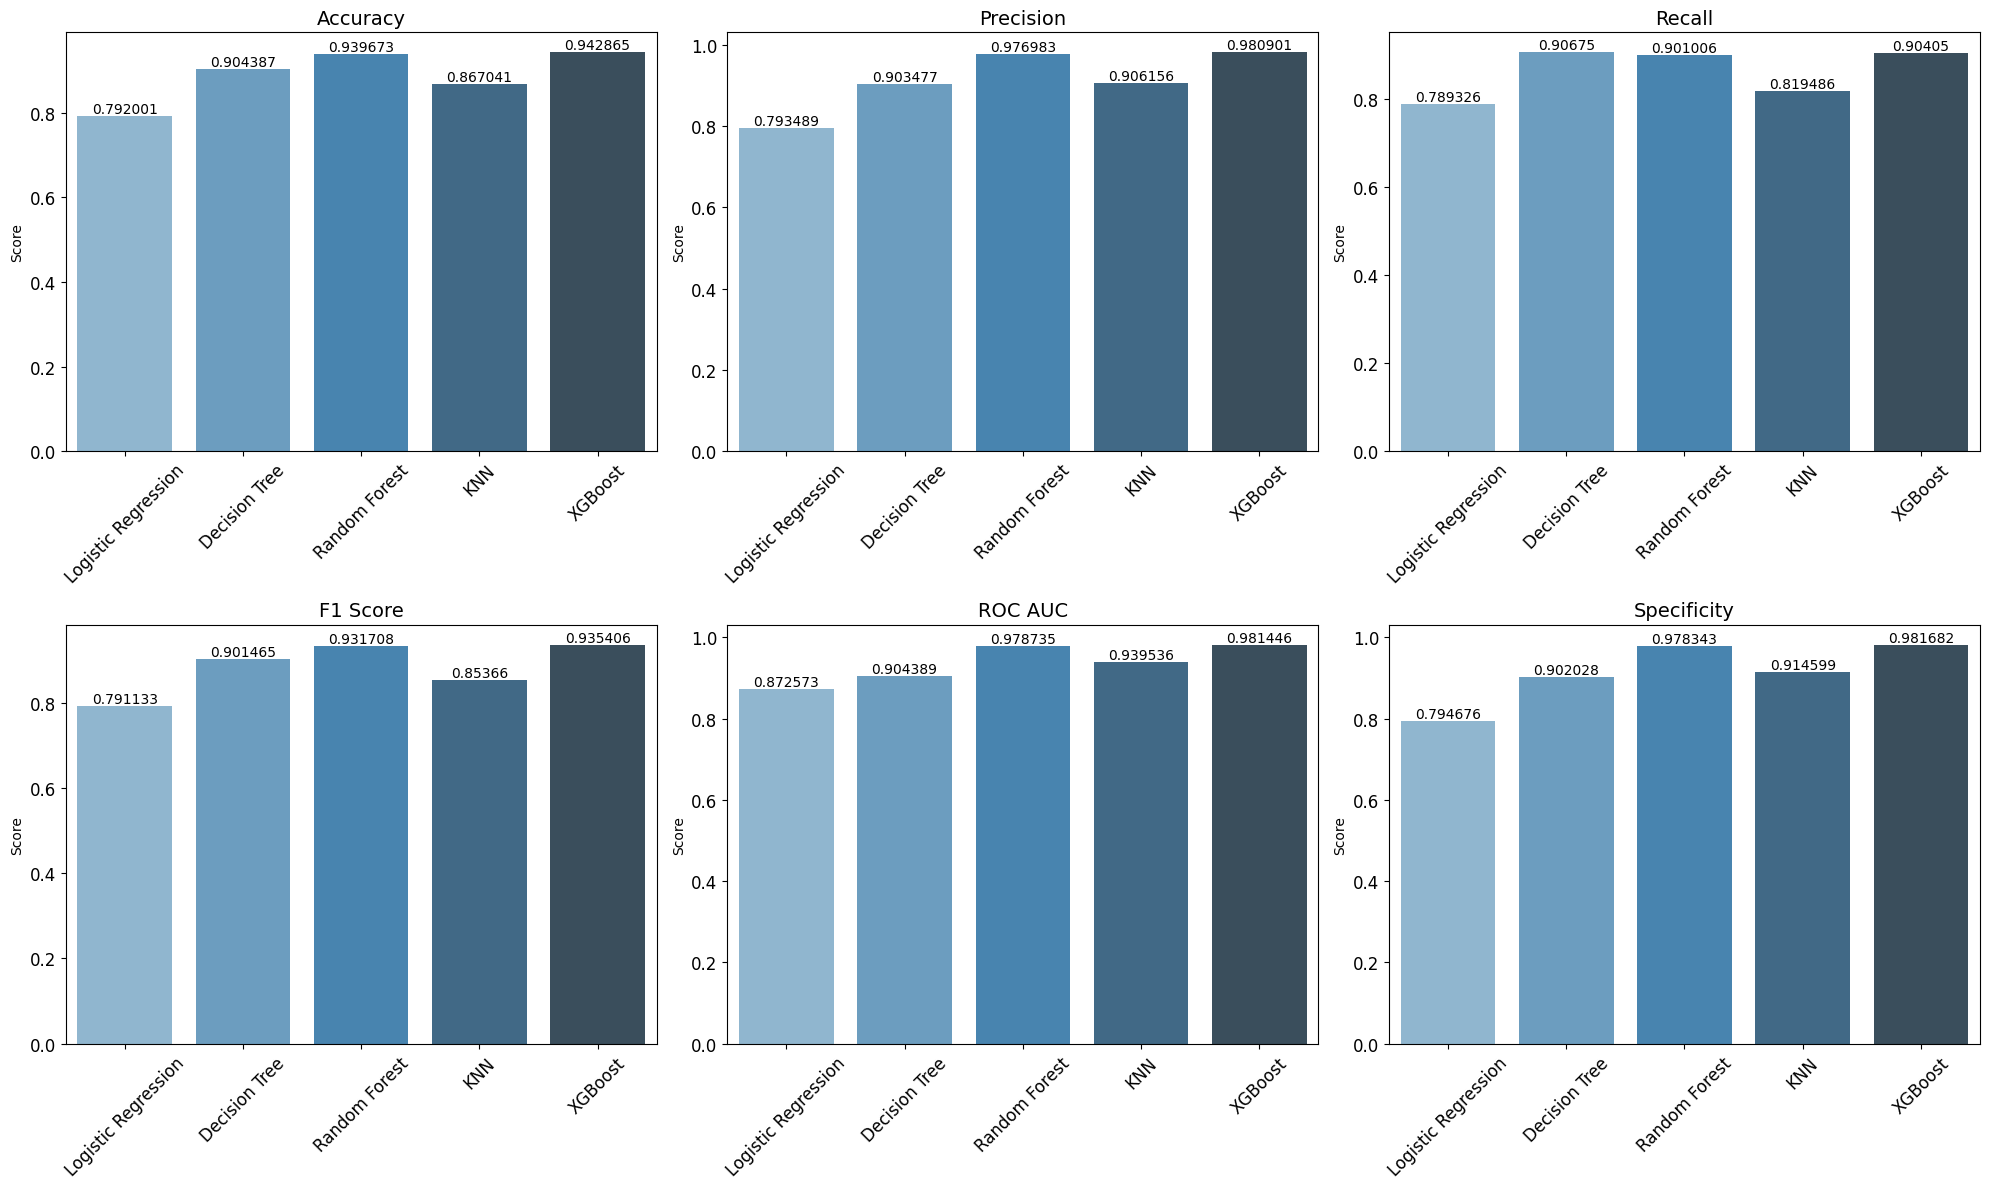

In [142]:
# Print the result in bar plot
# Create a dataframe from cross_validation result
df = pd.DataFrame.from_dict(evaluation_results_cv, orient='index')
palette = sns.color_palette("Blues_d", df.index.nunique())

plt.figure(figsize=(20,12))
for i, column in enumerate(df.columns):
    ax = plt.subplot(2,3,i + 1)  
    barplot = sns.barplot(x=df.index, y=df[column], palette=palette, hue=df.index, legend=False)
    plt.title(column, fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('')
    plt.ylabel('Score')
    for container in barplot.containers:
        ax.bar_label(container)
    plt.tight_layout()
    ax.grid(False)
    
plt.show()


In [136]:
# References: https://medium.com/@rithpansanga/optimizing-xgboost-a-guide-to-hyperparameter-tuning-77b6e48e289d
# Hyperparameter tuning
# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0.01, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1]
}

# Create the RandomizedSearchCV object
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=20)
random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=param_grid, n_iter=50, 
                                   scoring='f1', cv=5, verbose=1, random_state=20)

# Fit the random search model
random_search.fit(x_train_smote, y_train_smote)

# Get the best parameters and results
print("Best parameters found: ", random_search.best_params_)
print("Best F1 score achieved: ", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.1, 'reg_alpha': 1, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Best F1 score achieved:  0.9388222198239766


In [137]:
# Final Model
xgb_model = XGBClassifier(
    use_label_encoder=False,
    random_state=20,
    subsample=1.0,
    reg_lambda=0.1,
    reg_alpha=1,
    n_estimators=300,
    max_depth=9,
    learning_rate=0.1,
    colsample_bytree=0.6
)

xgb_model.fit(x_train_smote,y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=20, ...)

In [138]:
#References: https://towardsdatascience.com/complete-guide-on-model-deployment-with-flask-and-heroku-98c87554a6b9
# Save the model
filename = 'xgb_model.sav'
pickle.dump(xgb_model, open(filename, 'wb'))

filename = 'encoder_file.sav'
pickle.dump(ohe, open(filename, 'wb'))

filename = 'x_train.sav'
pickle.dump(pd.DataFrame(x_train_smote), open(filename, 'wb'))

filename = 'y_train.sav'
pickle.dump(pd.DataFrame(y_train_smote), open(filename, 'wb'))
